In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
df = pd.read_csv('fertilizer_recommendation_dataset.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())



(3100, 12)
   Temperature  Moisture    Rainfall        PH   Nitrogen  Phosphorous  \
0    50.179845  0.725893  205.600816  6.227358  66.701872    76.963560   
1    21.633318  0.721958  306.081601  7.173131  71.583316   163.057636   
2    23.060964  0.685751  259.336414  7.380793  75.709830    62.091508   
3    26.241975  0.755095  212.703513  6.883367  78.033687   151.012521   
4    21.490157  0.730672  268.786767  7.578760  71.765123    66.257371   

    Potassium    Carbon        Soil  Crop                  Fertilizer  \
0   96.429065  0.496300  Loamy Soil  rice                     Compost   
1  148.128347  1.234242  Loamy Soil  rice     Balanced NPK Fertilizer   
2   80.308971  1.795650  Peaty Soil  rice  Water Retaining Fertilizer   
3  153.005712  1.517556  Loamy Soil  rice     Balanced NPK Fertilizer   
4   97.000886  1.782985  Peaty Soil  rice          Organic Fertilizer   

                                              Remark  
0  Enhances organic matter and improves soil stru.

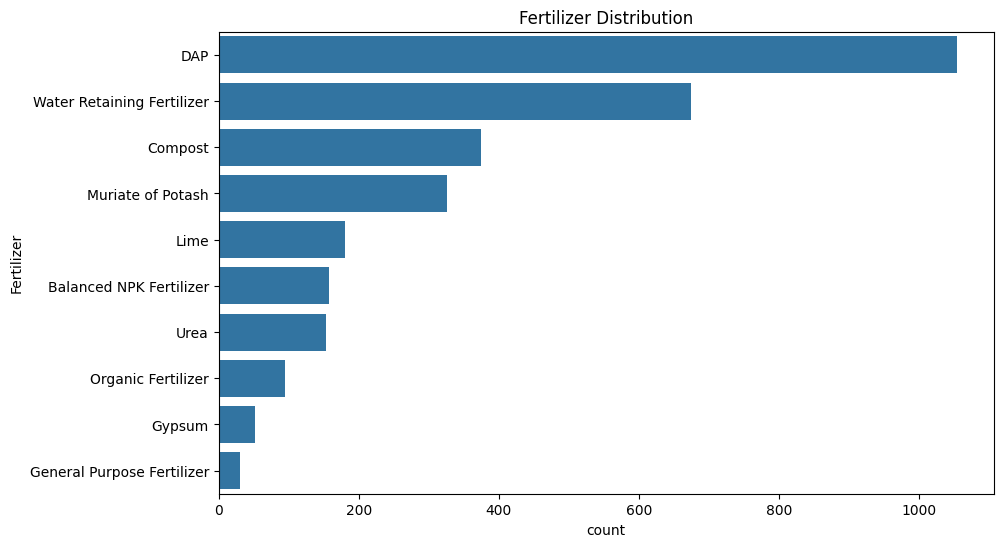

Fertilizer
DAP                           1054
Water Retaining Fertilizer     675
Compost                        375
Muriate of Potash              326
Lime                           181
Balanced NPK Fertilizer        157
Urea                           154
Organic Fertilizer              95
Gypsum                          52
General Purpose Fertilizer      31
Name: count, dtype: int64
Crop
rice            100
wheat           100
Mung Bean       100
Tea             100
millet          100
maize           100
Lentil          100
Jute            100
Coffee          100
Cotton          100
Ground Nut      100
Peas            100
Rubber          100
Sugarcane       100
Tobacco         100
Kidney Beans    100
Moth Beans      100
Coconut         100
Black gram      100
Adzuki Beans    100
Pigeon Peas     100
Chickpea        100
banana          100
grapes          100
apple           100
mango           100
muskmelon       100
orange          100
papaya          100
pomegranate     100
watermel

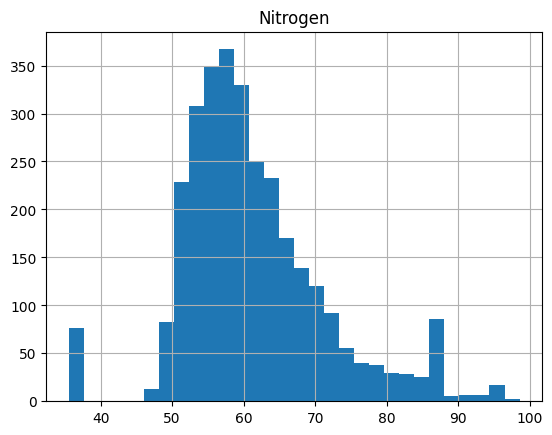

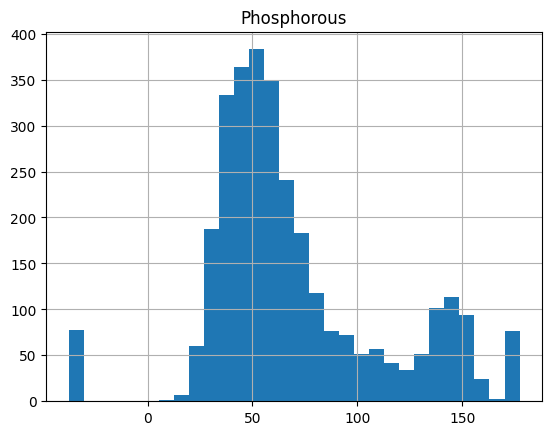

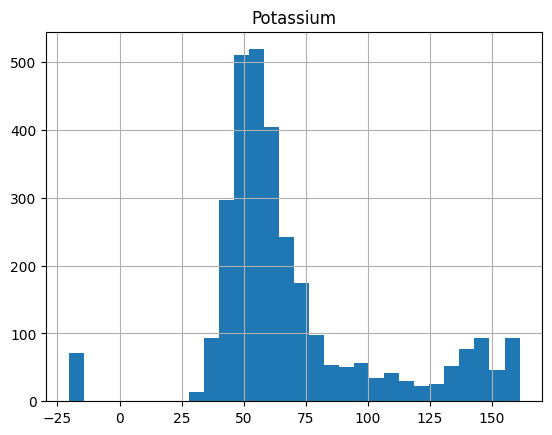

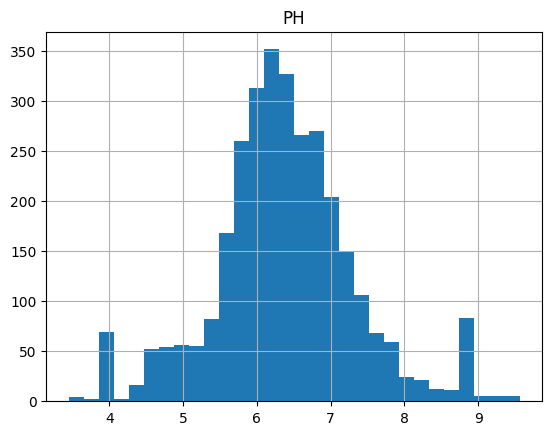

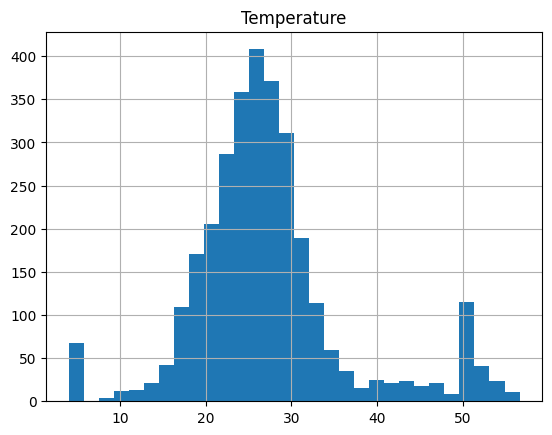

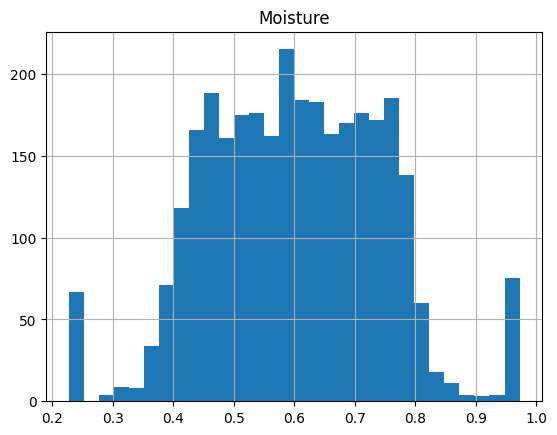

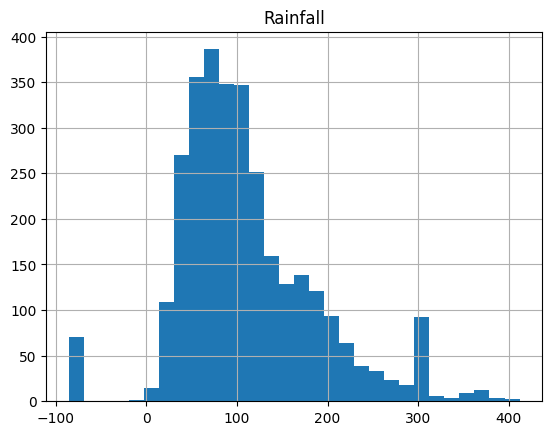

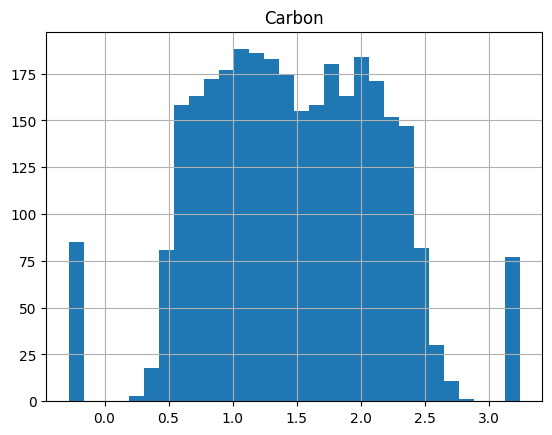

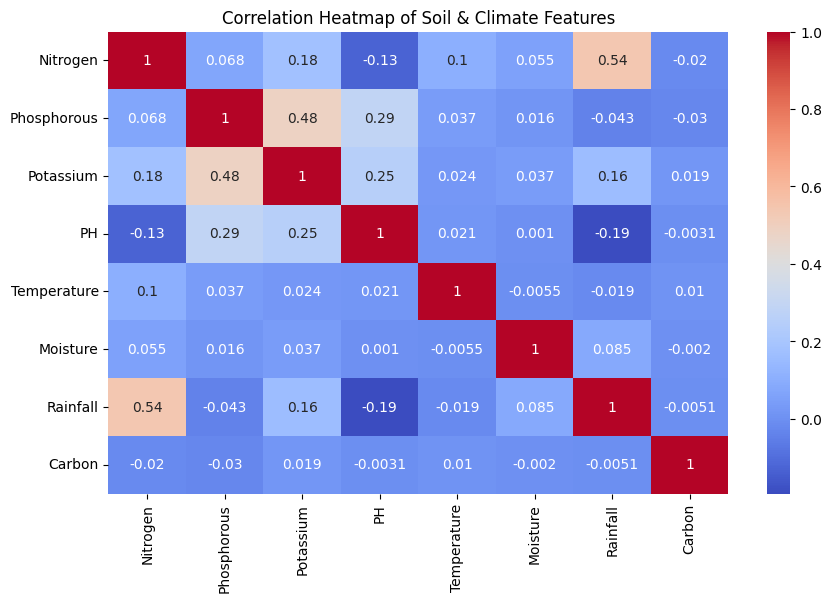

In [62]:
# Plot fertilizer distribution
plt.figure(figsize=(10,6))
sns.countplot(y='Fertilizer', data=df, order=df['Fertilizer'].value_counts().index)
plt.title("Fertilizer Distribution")
plt.show()

# Summary statistics
print(df['Fertilizer'].value_counts())
print(df['Crop'].value_counts())
print(df['Soil'].value_counts())

# Numeric columns visualization
numeric_cols = ['Nitrogen', 'Phosphorous', 'Potassium', 'PH', 'Temperature', 'Moisture', 'Rainfall', 'Carbon']
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

# Numeric correlations heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Soil & Climate Features")
plt.show()



In [63]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Label encode categorical variables
le_crop = LabelEncoder()
df['Crop_le'] = le_crop.fit_transform(df['Crop'])

le_soil = LabelEncoder()
df['Soil_le'] = le_soil.fit_transform(df['Soil'])

le_fert = LabelEncoder()
df['Fertilizer_le'] = le_fert.fit_transform(df['Fertilizer'])

# Save cleaned data optionally
df.to_csv('fertilizer_cleaned.csv', index=False)



Original shape: (3100, 15)
After outlier removal: (1761, 15)


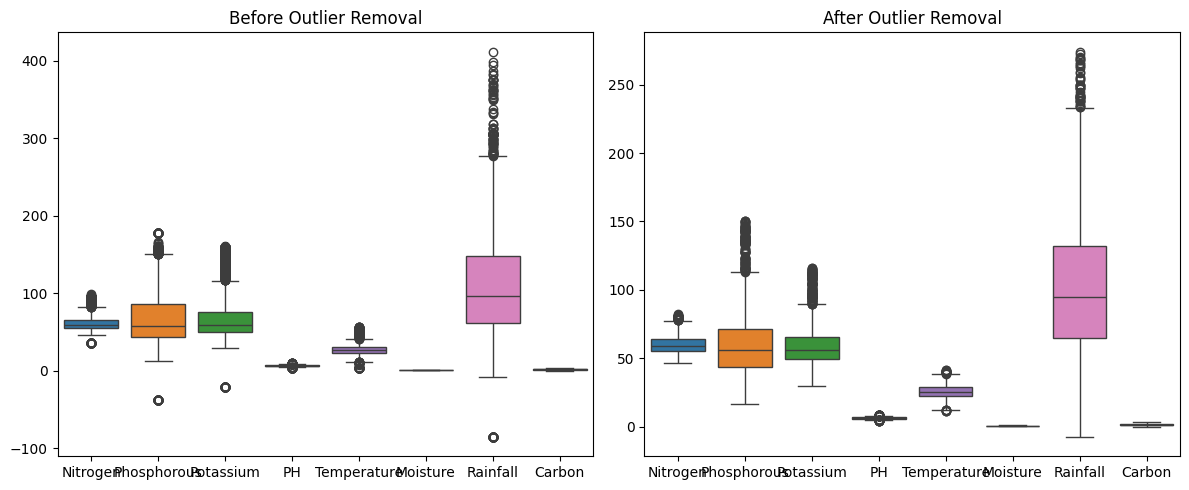

In [64]:
# Reload cleaned data
df = pd.read_csv('fertilizer_cleaned.csv')

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

df_clean = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)

print("Original shape:", df.shape)
print("After outlier removal:", df_clean.shape)

# Visual comparison
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df[numeric_cols])
plt.title("Before Outlier Removal")

plt.subplot(1,2,2)
sns.boxplot(data=df_clean[numeric_cols])
plt.title("After Outlier Removal")

plt.tight_layout()
plt.show()

# Use cleaned data for further processing
df = df_clean



In [81]:
print(df['Fertilizer'].value_counts())
print(df['Crop'].value_counts())
print(df['Soil'].value_counts())

Fertilizer
DAP                           626
Water Retaining Fertilizer    399
Compost                       215
Muriate of Potash             205
Lime                          114
Organic Fertilizer             70
Balanced NPK Fertilizer        61
Urea                           36
Name: count, dtype: int64
Crop
Tobacco         79
Tea             74
Kidney Beans    74
Ground Nut      73
apple           72
banana          70
grapes          70
Black gram      68
Peas            67
muskmelon       67
Cotton          66
Coconut         65
wheat           65
maize           64
mango           64
watermelon      63
Pigeon Peas     62
Lentil          62
Chickpea        59
Sugarcane       52
Mung Bean       51
Moth Beans      50
pomegranate     49
orange          47
rice            44
Jute            44
Coffee          36
Rubber          32
papaya          26
millet          11
Name: count, dtype: int64
Soil
Acidic Soil      1001
Peaty Soil        312
Neutral Soil      213
Loamy Soil        1

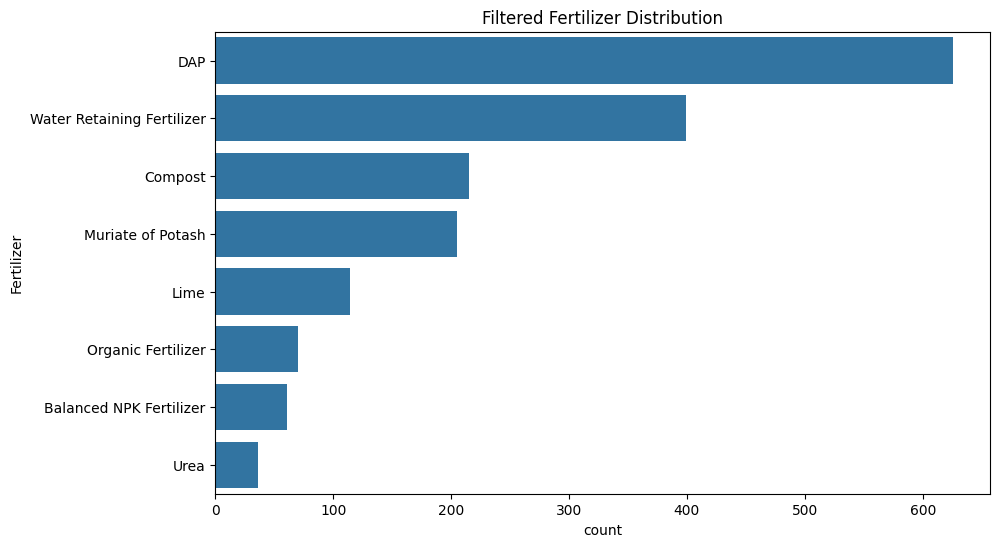

In [65]:
# Define fertilizer counts (can also be done by actual df counts)
fertilizer_counts = df['Fertilizer'].value_counts().to_dict()

threshold = 30
fertilizers_to_keep = [f for f, count in fertilizer_counts.items() if count >= threshold]

# Filter dataframe
df_filtered = df[df['Fertilizer'].isin(fertilizers_to_keep)].reset_index(drop=True)

# Plot filtered fertilizer distribution
plt.figure(figsize=(10,6))
sns.countplot(y='Fertilizer', data=df_filtered, order=df_filtered['Fertilizer'].value_counts().index)
plt.title("Filtered Fertilizer Distribution")
plt.show()

df = df_filtered



In [66]:
le_crop = LabelEncoder()
df['Crop_le'] = le_crop.fit_transform(df['Crop'])

le_soil = LabelEncoder()
df['Soil_le'] = le_soil.fit_transform(df['Soil'])

le_fert = LabelEncoder()
df['Fertilizer_le'] = le_fert.fit_transform(df['Fertilizer'])



In [88]:
features = ['Nitrogen','Phosphorous','Potassium','PH','Temperature','Moisture','Rainfall','Carbon', 'Crop_le', 'Soil_le']
X = df[features]
y = df['Fertilizer_le']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)



Train shape: (1380, 10)
Test shape: (346, 10)


Random Forest Accuracy: 0.9884169884169884

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.98      1.00      0.99        65
           2       0.98      1.00      0.99       188
           3       0.97      1.00      0.99        34
           4       1.00      1.00      1.00        61
           5       1.00      0.95      0.98        21
           6       1.00      0.64      0.78        11
           7       1.00      0.99      1.00       120

    accuracy                           0.99       518
   macro avg       0.99      0.95      0.96       518
weighted avg       0.99      0.99      0.99       518



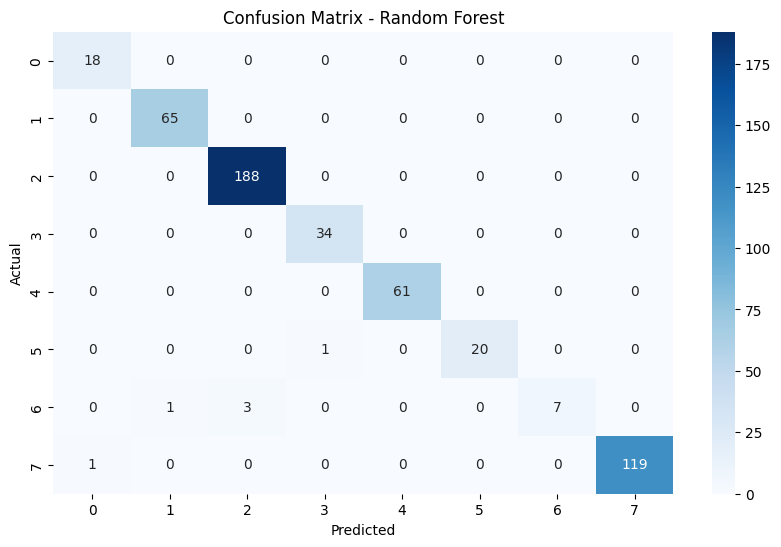

d:\B.Tech-CSE And BS\3rd year\mini project\project_codes\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9922779922779923

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        65
           2       0.99      0.99      0.99       188
           3       0.97      1.00      0.99        34
           4       1.00      0.98      0.99        61
           5       1.00      0.95      0.98        21
           6       0.92      1.00      0.96        11
           7       0.99      0.99      0.99       120

    accuracy                           0.99       518
   macro avg       0.98      0.99      0.99       518
weighted avg       0.99      0.99      0.99       518



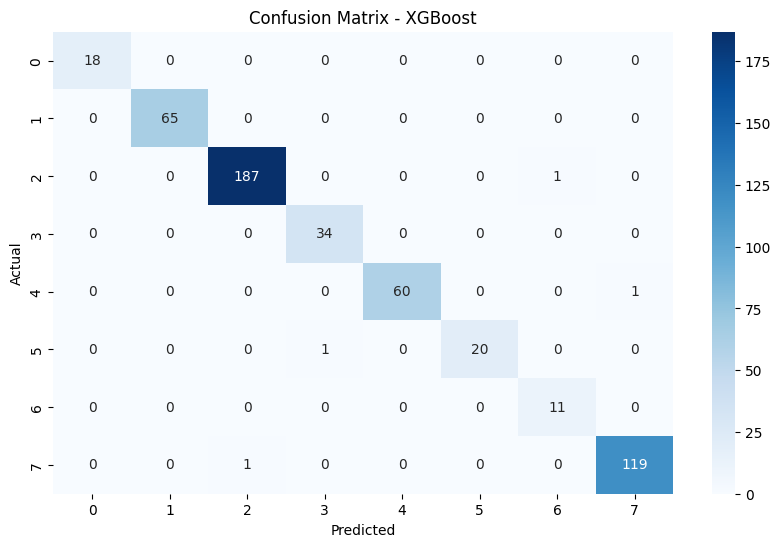

Decision Tree Accuracy: 0.9922779922779923

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00       188
           3       0.97      0.94      0.96        34
           4       1.00      1.00      1.00        61
           5       1.00      0.95      0.98        21
           6       1.00      1.00      1.00        11
           7       1.00      0.99      1.00       120

    accuracy                           0.99       518
   macro avg       0.98      0.99      0.98       518
weighted avg       0.99      0.99      0.99       518



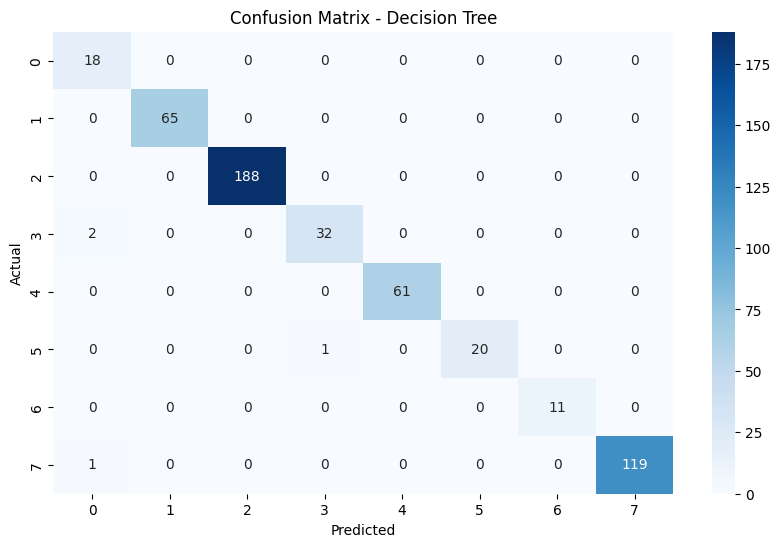

Logistic Regression Accuracy: 0.749034749034749

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.75      0.71      0.73        65
           2       0.84      0.93      0.88       188
           3       0.54      0.21      0.30        34
           4       0.75      0.75      0.75        61
           5       0.52      0.62      0.57        21
           6       0.50      0.18      0.27        11
           7       0.68      0.83      0.75       120

    accuracy                           0.75       518
   macro avg       0.57      0.53      0.53       518
weighted avg       0.71      0.75      0.72       518



d:\B.Tech-CSE And BS\3rd year\mini project\project_codes\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


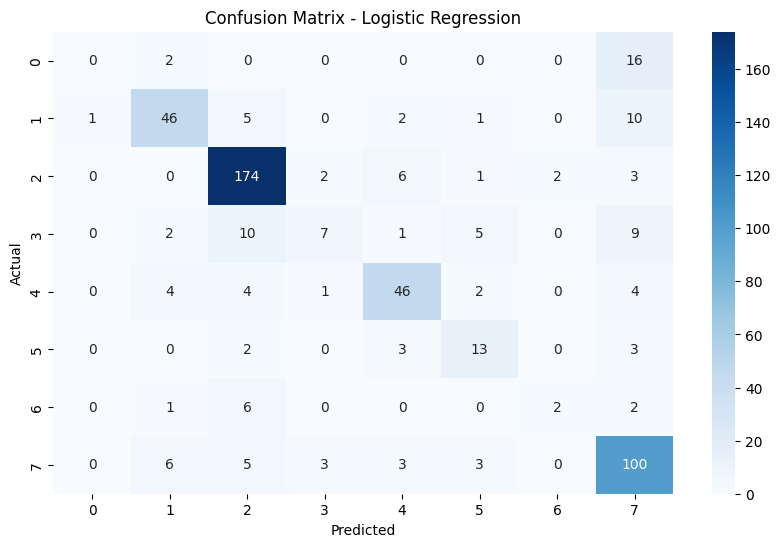

Gradient Boosting Accuracy: 1.0

Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00       188
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        61
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00       120

    accuracy                           1.00       518
   macro avg       1.00      1.00      1.00       518
weighted avg       1.00      1.00      1.00       518



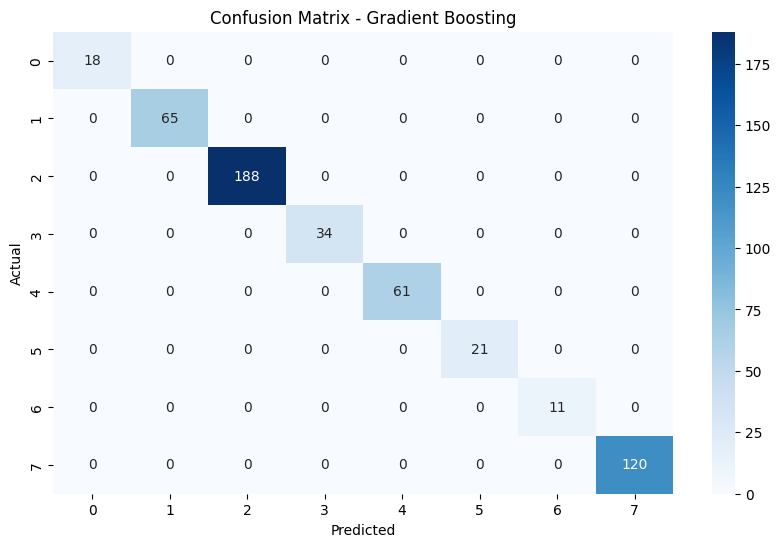

In [75]:


# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_acc=accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and evaluate XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_acc=accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_acc=accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and evaluate Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
lr_acc=accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and evaluate Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_acc=accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report for Gradient Boosting:\n", classification_report(y_test, y_pred_gb))
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\Shreyesh Singh\AppData\Local\Temp\ipykernel_7392\4231976944.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='viridis')


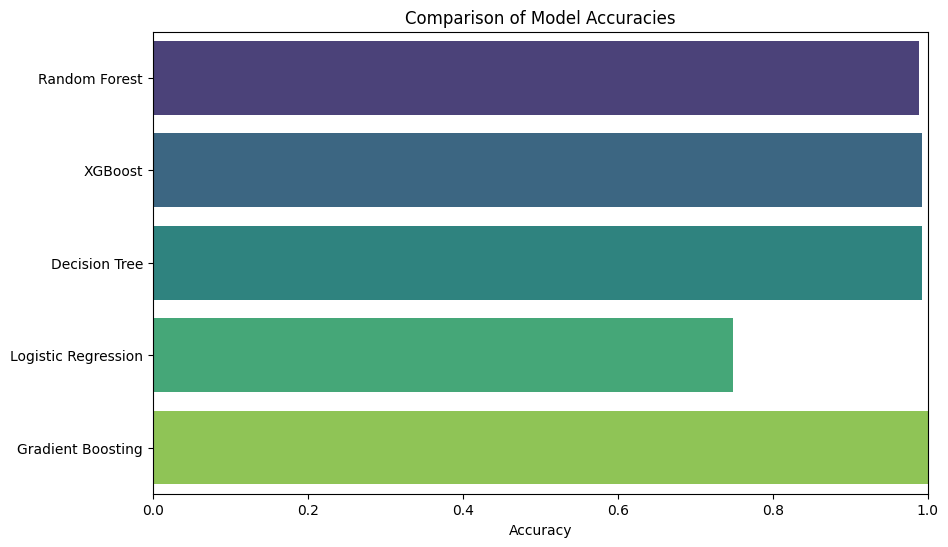

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names and their accuracies collected from your training
model_names = ['Random Forest', 'XGBoost', 'Decision Tree', 'Logistic Regression', 'Gradient Boosting']
accuracies = [rf_acc, xgb_acc, dt_acc, lr_acc, gb_acc]

# Plot horizontal bar chart for comparison
plt.figure(figsize=(10,6))
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.xlabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xlim(0, 1)
plt.show()


In [77]:



gb = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(gb, X, y, cv=cv, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Std CV accuracy:", np.std(cv_scores))



Cross-validated accuracy scores: [0.99421965 1.         1.         0.99130435 0.97971014]
Mean CV accuracy: 0.9930468291865628
Std CV accuracy: 0.0074695658930880975


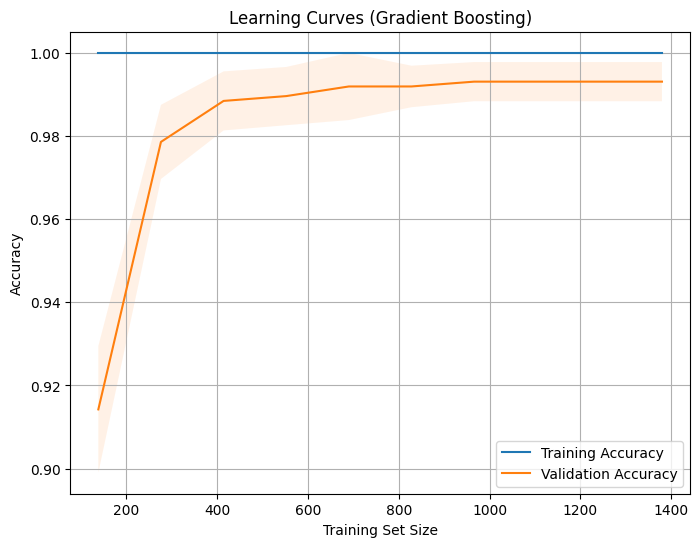

In [71]:
from sklearn.model_selection import learning_curve

gb = GradientBoostingClassifier(random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    gb, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves (Gradient Boosting)')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
# Assume best_model is the trained GradientBoostingClassifier model from earlier

new_crop = 'rice'             # example crop
new_soil = 'Loamy Soil'       # example soil

# Encode the categorical inputs using existing LabelEncoders fitted during training
new_crop_encoded = le_crop.transform([new_crop])[0]
new_soil_encoded = le_soil.transform([new_soil])[0]

new_data = {
    'Nitrogen': 72.836044,
    'Phosphorous': 94.668946,
    'Potassium': 111.020175,
    'PH': 7.343771,
    'Temperature': 26.950996,
    'Moisture': 0.227436,
    'Rainfall': 214.217539,
    'Carbon': 3.241984,
    'Crop_le': new_crop_encoded,
    'Soil_le': new_soil_encoded,
}

new_df = pd.DataFrame([new_data])

# Prediction without retraining
pred_label = gb_model.predict(new_df)[0]

# Convert label encoded prediction back to original fertilizer name
fertilizer_name = le_fert.inverse_transform([pred_label])[0]

print("Recommended Fertilizer:", fertilizer_name)




Recommended Fertilizer: Water Retaining Fertilizer


In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    plt.xlabel('Training Set Size')
    plt.ylabel(scoring.capitalize())
    plt.title('Learning Curve - Check Overfitting')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check overfitting condition based on final training and validation scores
    last_train = train_mean[-1]
    last_val = val_mean[-1]
    gap = last_train - last_val

    if gap > 0.05:
        print(f'Possible Overfitting: Training score ({last_train:.3f}) is much higher than Validation score ({last_val:.3f})')
    elif gap < 0:
        print('Possible Underfitting: Validation score is higher than Training score')
    else:
        print('Model generalizes well')


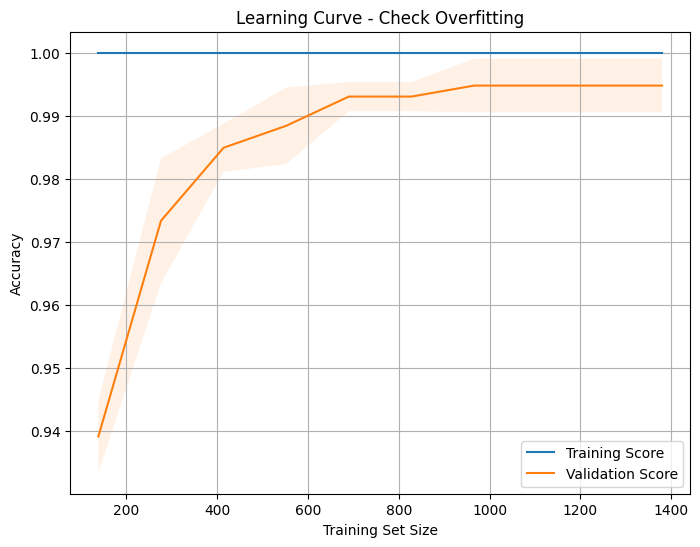

Model generalizes well


In [84]:
import numpy as np

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

plot_learning_curve(gb_model, X, y)


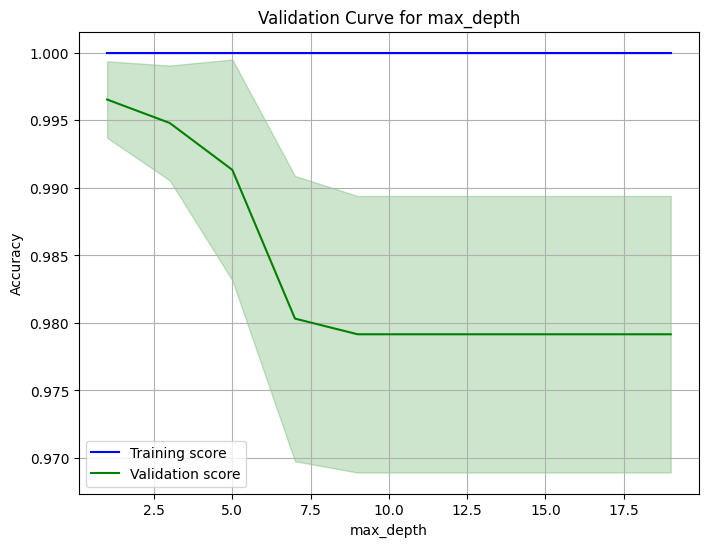

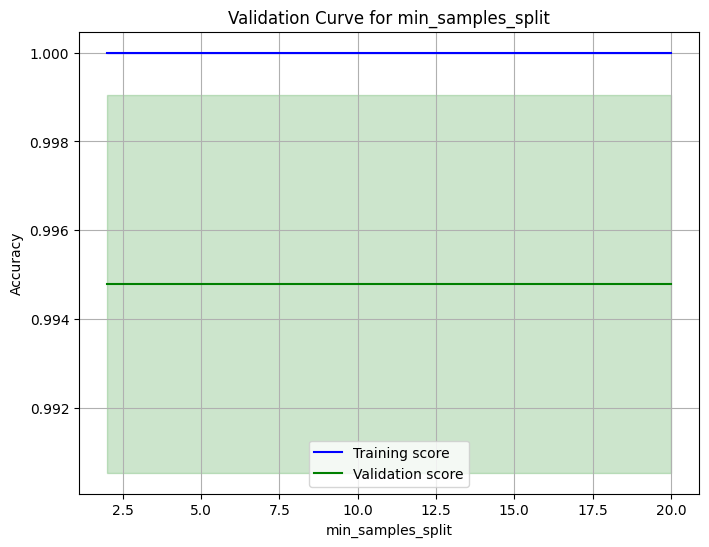

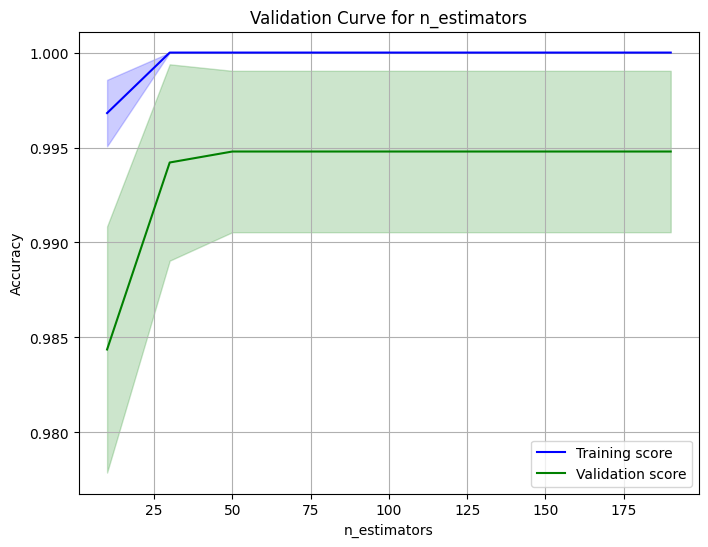

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import validation_curve

def plot_validation_curve(param_name, param_range, X, y):
    gb = GradientBoostingClassifier(random_state=42)
    train_scores, val_scores = validation_curve(
        gb, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(param_range, train_mean, label='Training score', color='blue')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.plot(param_range, val_mean, label='Validation score', color='green')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')
    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Example values for max_depth
max_depth_range = np.arange(1, 21, 2)
plot_validation_curve('max_depth', max_depth_range, X, y)

# Example values for min_samples_split
min_samples_split_range = np.arange(2, 21, 2)
plot_validation_curve('min_samples_split', min_samples_split_range, X, y)

# Example values for n_estimators
n_estimators_range = np.arange(10, 210, 20)
plot_validation_curve('n_estimators', n_estimators_range, X, y)


In [79]:
import pickle

# Rename variables as per your naming convention
gb_ferti_recc = gb_model
le_crop_ferti_recc = le_crop
le_soil_ferti_recc = le_soil
le_fert_ferti_recc = le_fert

objects_to_pickle = {
    "model": gb_ferti_recc,
    "le_crop": le_crop_ferti_recc,
    "le_soil": le_soil_ferti_recc,
    "le_fert": le_fert_ferti_recc,
}

with open('fertilizer_recommendation_model.pkl', 'wb') as f:
    pickle.dump(objects_to_pickle, f)


In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_best_rf))


Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best CV accuracy: 0.989855072463768
Test accuracy: 0.9855491329479769


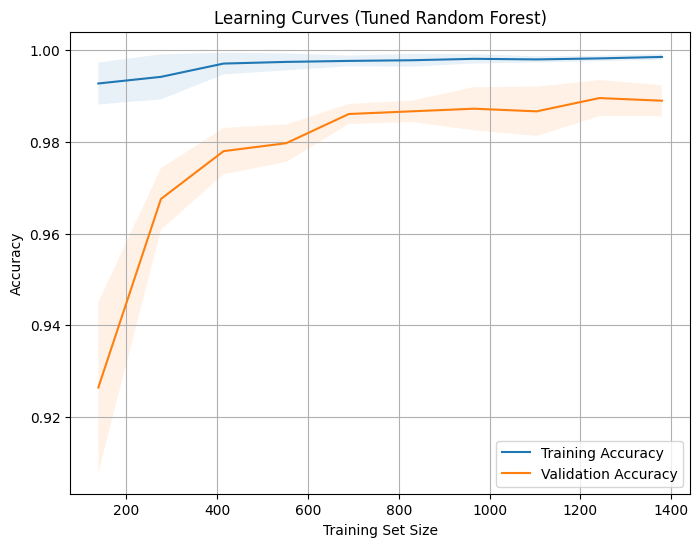

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Create model with best params from grid search
best_rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves (Tuned Random Forest)')
plt.legend()
plt.grid(True)
plt.show()
